In [1]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/home/sachin/.virtualenvs/keras_tf_p3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from tensorflow.examples.tutorials.mnist import input_data 
mnist = input_data.read_data_sets('data_set/')

Extracting data_set/train-images-idx3-ubyte.gz
Extracting data_set/train-labels-idx1-ubyte.gz
Extracting data_set/t10k-images-idx3-ubyte.gz
Extracting data_set/t10k-labels-idx1-ubyte.gz


In [3]:
x_train = mnist.train.images[:55000,:]
x_train.shape

(55000, 784)

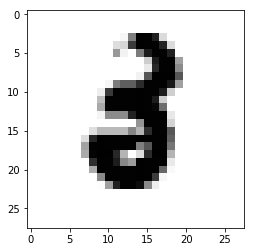

In [4]:
randomNum = random.randint(0,55000)
image = x_train[randomNum].reshape([28,28])
plt.imshow(image, cmap=plt.get_cmap('gray_r'))
plt.show()

In [5]:
def conv2d(x, W):
    return  tf.nn.conv2d(input=x , filter=W, strides = [1,1,1,1], padding='SAME')

def avg_pool_2x2(x):
    return tf.nn.avg_pool(x, ksize=[1,2,2,1], strides = [1,2,2,1], padding='SAME')


In [6]:
def discriminator(x_image, reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        #First Conv and Pool Layers
        W_conv1 = tf.get_variable('d_wconv1', [5, 5, 1, 8], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv1 = tf.get_variable('d_bconv1', [8], initializer=tf.constant_initializer(0))
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
        h_pool1 = avg_pool_2x2(h_conv1)

        #Second Conv and Pool Layers
        W_conv2 = tf.get_variable('d_wconv2', [5, 5, 8, 16], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv2 = tf.get_variable('d_bconv2', [16], initializer=tf.constant_initializer(0))
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = avg_pool_2x2(h_conv2)

        #First Fully Connected Layer
        W_fc1 = tf.get_variable('d_wfc1', [7 * 7 * 16, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc1 = tf.get_variable('d_bfc1', [32], initializer=tf.constant_initializer(0))
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*16])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

        #Second Fully Connected Layer
        W_fc2 = tf.get_variable('d_wfc2', [32, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc2 = tf.get_variable('d_bfc2', [1], initializer=tf.constant_initializer(0))

        #Final Layer
        y_conv=(tf.matmul(h_fc1, W_fc2) + b_fc2)
    return y_conv

In [7]:
def generator(z, batch_size, z_dim, reuse=False):
    with tf.variable_scope('generator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        g_dim = 64 #Number of filters of first layer of generator 
        c_dim = 1 #Color dimension of output (MNIST is grayscale, so c_dim = 1 for us)
        s = 28 #Output size of the image
        s2, s4, s8, s16 = int(s/2), int(s/4), int(s/8), int(s/16) #We want to slowly upscale the image, so these values will help
                                                                  #make that change gradual.

        h0 = tf.reshape(z, [batch_size, s16+1, s16+1, 25])
        h0 = tf.nn.relu(h0)
        #Dimensions of h0 = batch_size x 2 x 2 x 25

        #First DeConv Layer
        output1_shape = [batch_size, s8, s8, g_dim*4]
        W_conv1 = tf.get_variable('g_wconv1', [5, 5, output1_shape[-1], int(h0.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv1 = tf.get_variable('g_bconv1', [output1_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv1 = tf.nn.conv2d_transpose(h0, W_conv1, output_shape=output1_shape, strides=[1, 2, 2, 1], padding='SAME')
        H_conv1 = tf.contrib.layers.batch_norm(inputs = H_conv1, center=True, scale=True, is_training=True, scope="g_bn1")
        H_conv1 = tf.nn.relu(H_conv1)
        #Dimensions of H_conv1 = batch_size x 3 x 3 x 256

        #Second DeConv Layer
        output2_shape = [batch_size, s4 - 1, s4 - 1, g_dim*2]
        W_conv2 = tf.get_variable('g_wconv2', [5, 5, output2_shape[-1], int(H_conv1.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv2 = tf.get_variable('g_bconv2', [output2_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv2 = tf.nn.conv2d_transpose(H_conv1, W_conv2, output_shape=output2_shape, strides=[1, 2, 2, 1], padding='SAME')
        H_conv2 = tf.contrib.layers.batch_norm(inputs = H_conv2, center=True, scale=True, is_training=True, scope="g_bn2")
        H_conv2 = tf.nn.relu(H_conv2)
        #Dimensions of H_conv2 = batch_size x 6 x 6 x 128

        #Third DeConv Layer
        output3_shape = [batch_size, s2 - 2, s2 - 2, g_dim*1]
        W_conv3 = tf.get_variable('g_wconv3', [5, 5, output3_shape[-1], int(H_conv2.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv3 = tf.get_variable('g_bconv3', [output3_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv3 = tf.nn.conv2d_transpose(H_conv2, W_conv3, output_shape=output3_shape, strides=[1, 2, 2, 1], padding='SAME')
        H_conv3 = tf.contrib.layers.batch_norm(inputs = H_conv3, center=True, scale=True, is_training=True, scope="g_bn3")
        H_conv3 = tf.nn.relu(H_conv3)
        #Dimensions of H_conv3 = batch_size x 12 x 12 x 64

        #Fourth DeConv Layer
        output4_shape = [batch_size, s, s, c_dim]
        W_conv4 = tf.get_variable('g_wconv4', [5, 5, output4_shape[-1], int(H_conv3.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv4 = tf.get_variable('g_bconv4', [output4_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv4 = tf.nn.conv2d_transpose(H_conv3, W_conv4, output_shape=output4_shape, strides=[1, 2, 2, 1], padding='VALID')
        H_conv4 = tf.nn.tanh(H_conv4)
        #Dimensions of H_conv4 = batch_size x 28 x 28 x 1

    return H_conv4

In [8]:
sess = tf.Session()
z_dimensions = 100
z_test_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

In [9]:
sample_image = generator(z_test_placeholder, 1, z_dimensions)
test_z = np.random.normal(-1, 1, [1,z_dimensions])

In [10]:
sess.run(tf.global_variables_initializer())
temp = (sess.run(sample_image, feed_dict={z_test_placeholder: test_z}))

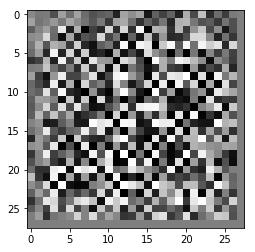

In [11]:
my_i = temp.squeeze()
plt.imshow(my_i, cmap='gray_r')
plt.show()

In [12]:
batch_size = 16
tf.reset_default_graph() #Since we changed our batch size (from 1 to 16), we need to reset our Tensorflow graph

sess = tf.Session()
x_placeholder = tf.placeholder("float", shape = [None,28,28,1]) #Placeholder for input images to the discriminator
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions]) #Placeholder for input noise vectors to the generator

In [13]:
Dx = discriminator(x_placeholder) #Dx will hold discriminator outputs (unnormalized) for the real MNIST images
Gz = generator(z_placeholder, batch_size, z_dimensions) #Gz holds the generated images
Dg = discriminator(Gz, reuse=True) #Dg will hold discriminator outputs (unnormalized) for generated images

In [14]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

In [15]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))
d_loss = d_loss_real + d_loss_fake

In [16]:
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

In [17]:
with tf.variable_scope(tf.get_variable_scope(), reuse=False):
    trainerD = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_vars)
    trainerG = tf.train.AdamOptimizer().minimize(g_loss, var_list=g_vars)

In [20]:
sess.run(tf.global_variables_initializer())
iterations = 3000
for i in range(iterations):
    z_batch = np.random.normal(-1, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)
    real_image_batch = np.reshape(real_image_batch[0],[batch_size,28,28,1])
    _,dLoss = sess.run([trainerD, d_loss],feed_dict={z_placeholder:z_batch,x_placeholder:real_image_batch}) #Update the discriminator
    _,gLoss = sess.run([trainerG,g_loss],feed_dict={z_placeholder:z_batch}) #Update the generator
    print('dLoss:',dLoss,'gLoss' ,gLoss)
    print('========Iterations:',i,' ===========')


dLoss: 1.386339 gLoss 0.6938093
========Iterations: 0  ===========
dLoss: 1.3861811 gLoss 0.6936993
========Iterations: 1  ===========
dLoss: 1.3860105 gLoss 0.69362193
========Iterations: 2  ===========
dLoss: 1.3857236 gLoss 0.69374764
========Iterations: 3  ===========
dLoss: 1.3853059 gLoss 0.6941813
========Iterations: 4  ===========
dLoss: 1.3847275 gLoss 0.6949873
========Iterations: 5  ===========
dLoss: 1.3839571 gLoss 0.6962254
========Iterations: 6  ===========
dLoss: 1.3829653 gLoss 0.69793487
========Iterations: 7  ===========
dLoss: 1.3816133 gLoss 0.7009411
========Iterations: 8  ===========
dLoss: 1.3796103 gLoss 0.7048713
========Iterations: 9  ===========
dLoss: 1.3770926 gLoss 0.7103733
========Iterations: 10  ===========
dLoss: 1.3748711 gLoss 0.71468973
========Iterations: 11  ===========
dLoss: 1.3724136 gLoss 0.7200433
========Iterations: 12  ===========
dLoss: 1.3770888 gLoss 0.7204996
========Iterations: 13  ===========
dLoss: 1.3744236 gLoss 0.7218633
========

dLoss: 1.3449059 gLoss 0.64302516
========Iterations: 120  ===========
dLoss: 1.340456 gLoss 0.6502208
========Iterations: 121  ===========
dLoss: 1.385893 gLoss 0.6612477
========Iterations: 122  ===========
dLoss: 1.3617178 gLoss 0.6480241
========Iterations: 123  ===========
dLoss: 1.3752873 gLoss 0.6359781
========Iterations: 124  ===========
dLoss: 1.3308494 gLoss 0.6352259
========Iterations: 125  ===========
dLoss: 1.409762 gLoss 0.6224397
========Iterations: 126  ===========
dLoss: 1.3659698 gLoss 0.6147944
========Iterations: 127  ===========
dLoss: 1.3790932 gLoss 0.6167691
========Iterations: 128  ===========
dLoss: 1.3575122 gLoss 0.6047847
========Iterations: 129  ===========
dLoss: 1.3996165 gLoss 0.60098976
========Iterations: 130  ===========
dLoss: 1.3783894 gLoss 0.60632265
========Iterations: 131  ===========
dLoss: 1.4056765 gLoss 0.6009275
========Iterations: 132  ===========
dLoss: 1.3783395 gLoss 0.587649
========Iterations: 133  ===========
dLoss: 1.4221814 gLos

dLoss: 1.0991851 gLoss 1.0796143
========Iterations: 238  ===========
dLoss: 1.100762 gLoss 0.802932
========Iterations: 239  ===========
dLoss: 1.1163018 gLoss 0.7823545
========Iterations: 240  ===========
dLoss: 1.2198989 gLoss 0.8039163
========Iterations: 241  ===========
dLoss: 1.366312 gLoss 0.9174798
========Iterations: 242  ===========
dLoss: 1.2201041 gLoss 1.1787136
========Iterations: 243  ===========
dLoss: 1.2584937 gLoss 1.2225902
========Iterations: 244  ===========
dLoss: 1.2539442 gLoss 1.0016164
========Iterations: 245  ===========
dLoss: 1.1179659 gLoss 0.85633576
========Iterations: 246  ===========
dLoss: 1.0458682 gLoss 1.0596766
========Iterations: 247  ===========
dLoss: 0.9151739 gLoss 1.5795245
========Iterations: 248  ===========
dLoss: 0.9801641 gLoss 1.7797849
========Iterations: 249  ===========
dLoss: 1.3489676 gLoss 1.1273032
========Iterations: 250  ===========
dLoss: 1.4217421 gLoss 0.61131746
========Iterations: 251  ===========
dLoss: 1.3839879 gLos

dLoss: 0.6234461 gLoss 1.9649645
========Iterations: 355  ===========
dLoss: 0.7907914 gLoss 1.5817088
========Iterations: 356  ===========
dLoss: 1.1001478 gLoss 1.284461
========Iterations: 357  ===========
dLoss: 1.0819302 gLoss 1.4100854
========Iterations: 358  ===========
dLoss: 1.1228426 gLoss 1.3411386
========Iterations: 359  ===========
dLoss: 0.8476504 gLoss 1.6041864
========Iterations: 360  ===========
dLoss: 1.0684706 gLoss 1.4922292
========Iterations: 361  ===========
dLoss: 0.84612834 gLoss 1.6460351
========Iterations: 362  ===========
dLoss: 0.9558712 gLoss 1.4213185
========Iterations: 363  ===========
dLoss: 0.9374075 gLoss 1.4479442
========Iterations: 364  ===========
dLoss: 1.2236536 gLoss 1.3080541
========Iterations: 365  ===========
dLoss: 1.0192106 gLoss 1.1326978
========Iterations: 366  ===========
dLoss: 0.776778 gLoss 1.2720864
========Iterations: 367  ===========
dLoss: 1.0100979 gLoss 1.3511285
========Iterations: 368  ===========
dLoss: 1.0807767 gLos

dLoss: 0.840771 gLoss 1.814955
========Iterations: 472  ===========
dLoss: 0.4879854 gLoss 0.9376688
========Iterations: 473  ===========
dLoss: 0.76701576 gLoss 1.4157293
========Iterations: 474  ===========
dLoss: 0.8062471 gLoss 2.471364
========Iterations: 475  ===========
dLoss: 0.5241505 gLoss 3.660616
========Iterations: 476  ===========
dLoss: 0.77563334 gLoss 3.4328856
========Iterations: 477  ===========
dLoss: 0.5922278 gLoss 2.729886
========Iterations: 478  ===========
dLoss: 0.4187441 gLoss 1.3611774
========Iterations: 479  ===========
dLoss: 0.4718698 gLoss 1.1555159
========Iterations: 480  ===========
dLoss: 0.6273663 gLoss 1.3173273
========Iterations: 481  ===========
dLoss: 0.5532181 gLoss 2.1495552
========Iterations: 482  ===========
dLoss: 0.4160257 gLoss 3.018806
========Iterations: 483  ===========
dLoss: 0.46705186 gLoss 3.4446807
========Iterations: 484  ===========
dLoss: 0.46729943 gLoss 2.9842708
========Iterations: 485  ===========
dLoss: 0.35746554 gLos

dLoss: 0.4276835 gLoss 3.7439003
========Iterations: 591  ===========
dLoss: 0.50638974 gLoss 1.6734719
========Iterations: 592  ===========
dLoss: 0.37047422 gLoss 1.3734959
========Iterations: 593  ===========
dLoss: 0.41645324 gLoss 2.3785453
========Iterations: 594  ===========
dLoss: 0.21000642 gLoss 4.170777
========Iterations: 595  ===========
dLoss: 0.40012628 gLoss 4.7319565
========Iterations: 596  ===========
dLoss: 0.4258269 gLoss 3.7923326
========Iterations: 597  ===========
dLoss: 0.25446832 gLoss 3.1379166
========Iterations: 598  ===========
dLoss: 0.40252644 gLoss 1.2585138
========Iterations: 599  ===========
dLoss: 0.41433114 gLoss 1.320689
========Iterations: 600  ===========
dLoss: 0.50754386 gLoss 2.6041625
========Iterations: 601  ===========
dLoss: 0.5276436 gLoss 3.3849266
========Iterations: 602  ===========
dLoss: 0.21530981 gLoss 3.9020338
========Iterations: 603  ===========
dLoss: 0.39809254 gLoss 4.233122
========Iterations: 604  ===========
dLoss: 0.171

dLoss: 0.19544321 gLoss 1.7958754
========Iterations: 708  ===========
dLoss: 0.20791376 gLoss 1.243531
========Iterations: 709  ===========
dLoss: 0.620373 gLoss 2.5369334
========Iterations: 710  ===========
dLoss: 0.47908866 gLoss 3.8742886
========Iterations: 711  ===========
dLoss: 0.2522106 gLoss 5.1550236
========Iterations: 712  ===========
dLoss: 0.25880036 gLoss 5.1696715
========Iterations: 713  ===========
dLoss: 0.217843 gLoss 4.554904
========Iterations: 714  ===========
dLoss: 0.24698624 gLoss 3.546412
========Iterations: 715  ===========
dLoss: 0.07412345 gLoss 2.3220706
========Iterations: 716  ===========
dLoss: 0.19558765 gLoss 1.9885492
========Iterations: 717  ===========
dLoss: 0.20343913 gLoss 2.7747831
========Iterations: 718  ===========
dLoss: 0.3099019 gLoss 3.4893425
========Iterations: 719  ===========
dLoss: 0.24310133 gLoss 3.718446
========Iterations: 720  ===========
dLoss: 0.12652971 gLoss 3.5125453
========Iterations: 721  ===========
dLoss: 0.6490775

dLoss: 1.1981988 gLoss 7.7495565
========Iterations: 825  ===========
dLoss: 1.0501523 gLoss 1.6923118
========Iterations: 826  ===========
dLoss: 0.4422122 gLoss 0.6508993
========Iterations: 827  ===========
dLoss: 0.36981276 gLoss 3.2409985
========Iterations: 828  ===========
dLoss: 0.2728581 gLoss 4.525304
========Iterations: 829  ===========
dLoss: 0.43274337 gLoss 4.6198273
========Iterations: 830  ===========
dLoss: 0.131417 gLoss 4.7076974
========Iterations: 831  ===========
dLoss: 0.045610037 gLoss 4.5202575
========Iterations: 832  ===========
dLoss: 0.04262398 gLoss 4.5576553
========Iterations: 833  ===========
dLoss: 0.04100483 gLoss 4.9144487
========Iterations: 834  ===========
dLoss: 0.26682395 gLoss 4.9909387
========Iterations: 835  ===========
dLoss: 0.12667167 gLoss 4.1276073
========Iterations: 836  ===========
dLoss: 0.12855336 gLoss 3.0719368
========Iterations: 837  ===========
dLoss: 0.1362668 gLoss 3.5714297
========Iterations: 838  ===========
dLoss: 0.5995

dLoss: 0.18088698 gLoss 2.7774835
========Iterations: 942  ===========
dLoss: 0.12944585 gLoss 3.0072613
========Iterations: 943  ===========
dLoss: 0.2767626 gLoss 2.9400165
========Iterations: 944  ===========
dLoss: 0.33743295 gLoss 2.5355644
========Iterations: 945  ===========
dLoss: 0.47194362 gLoss 2.070619
========Iterations: 946  ===========
dLoss: 0.26224127 gLoss 2.6335535
========Iterations: 947  ===========
dLoss: 0.34767872 gLoss 2.3882372
========Iterations: 948  ===========
dLoss: 0.20595899 gLoss 2.9777288
========Iterations: 949  ===========
dLoss: 1.2085245 gLoss 1.9105161
========Iterations: 950  ===========
dLoss: 0.4125389 gLoss 1.7564126
========Iterations: 951  ===========
dLoss: 0.23890433 gLoss 3.332387
========Iterations: 952  ===========
dLoss: 0.33321175 gLoss 4.5809026
========Iterations: 953  ===========
dLoss: 0.051334556 gLoss 5.3546834
========Iterations: 954  ===========
dLoss: 0.13571858 gLoss 4.871789
========Iterations: 955  ===========
dLoss: 0.29

dLoss: 0.07226021 gLoss 3.8123481
========Iterations: 1059  ===========
dLoss: 0.05593738 gLoss 3.1520388
========Iterations: 1060  ===========
dLoss: 0.1191218 gLoss 3.0164511
========Iterations: 1061  ===========
dLoss: 0.10018901 gLoss 4.0493736
========Iterations: 1062  ===========
dLoss: 0.037504975 gLoss 5.199875
========Iterations: 1063  ===========
dLoss: 0.011721264 gLoss 6.5332375
========Iterations: 1064  ===========
dLoss: 0.028950702 gLoss 7.17267
========Iterations: 1065  ===========
dLoss: 0.055815328 gLoss 8.086975
========Iterations: 1066  ===========
dLoss: 0.08823049 gLoss 6.693959
========Iterations: 1067  ===========
dLoss: 0.010439042 gLoss 6.928763
========Iterations: 1068  ===========
dLoss: 0.035248633 gLoss 6.137438
========Iterations: 1069  ===========
dLoss: 0.037671242 gLoss 5.189288
========Iterations: 1070  ===========
dLoss: 0.038803153 gLoss 4.1308208
========Iterations: 1071  ===========
dLoss: 0.024559816 gLoss 4.5420475
========Iterations: 1072  ====

dLoss: 0.23177181 gLoss 4.7641745
========Iterations: 1173  ===========
dLoss: 0.40625346 gLoss 3.0659554
========Iterations: 1174  ===========
dLoss: 0.3043779 gLoss 1.2535199
========Iterations: 1175  ===========
dLoss: 0.53448695 gLoss 3.1832638
========Iterations: 1176  ===========
dLoss: 0.45101076 gLoss 3.9080973
========Iterations: 1177  ===========
dLoss: 0.12805855 gLoss 4.1167846
========Iterations: 1178  ===========
dLoss: 0.05239179 gLoss 4.364526
========Iterations: 1179  ===========
dLoss: 0.1304528 gLoss 4.0563016
========Iterations: 1180  ===========
dLoss: 0.3281303 gLoss 2.7549922
========Iterations: 1181  ===========
dLoss: 0.21101137 gLoss 2.0288954
========Iterations: 1182  ===========
dLoss: 0.7090336 gLoss 1.75088
========Iterations: 1183  ===========
dLoss: 0.28554982 gLoss 3.650434
========Iterations: 1184  ===========
dLoss: 0.11796503 gLoss 5.358361
========Iterations: 1185  ===========
dLoss: 0.17934567 gLoss 5.8417273
========Iterations: 1186  ===========
d

dLoss: 0.09315233 gLoss 3.0819414
========Iterations: 1290  ===========
dLoss: 0.10712067 gLoss 3.8566113
========Iterations: 1291  ===========
dLoss: 0.15901917 gLoss 4.734887
========Iterations: 1292  ===========
dLoss: 0.020236649 gLoss 5.7317142
========Iterations: 1293  ===========
dLoss: 0.021883257 gLoss 6.376934
========Iterations: 1294  ===========
dLoss: 0.23100457 gLoss 6.5454674
========Iterations: 1295  ===========
dLoss: 0.01857232 gLoss 6.4876585
========Iterations: 1296  ===========
dLoss: 0.005320169 gLoss 6.5931883
========Iterations: 1297  ===========
dLoss: 0.083745115 gLoss 5.936452
========Iterations: 1298  ===========
dLoss: 0.057434432 gLoss 4.584228
========Iterations: 1299  ===========
dLoss: 0.23920827 gLoss 3.3587575
========Iterations: 1300  ===========
dLoss: 0.032774158 gLoss 3.2085106
========Iterations: 1301  ===========
dLoss: 0.06672957 gLoss 2.951612
========Iterations: 1302  ===========
dLoss: 0.06634079 gLoss 3.3519921
========Iterations: 1303  ===

dLoss: 0.028326422 gLoss 4.0818057
========Iterations: 1404  ===========
dLoss: 0.039642613 gLoss 4.200819
========Iterations: 1405  ===========
dLoss: 0.18972015 gLoss 3.890633
========Iterations: 1406  ===========
dLoss: 0.052353814 gLoss 3.7943506
========Iterations: 1407  ===========
dLoss: 0.03403605 gLoss 3.8052425
========Iterations: 1408  ===========
dLoss: 0.08873144 gLoss 3.7702022
========Iterations: 1409  ===========
dLoss: 0.02853956 gLoss 4.13043
========Iterations: 1410  ===========
dLoss: 0.039918333 gLoss 4.3647556
========Iterations: 1411  ===========
dLoss: 0.023554377 gLoss 4.8011875
========Iterations: 1412  ===========
dLoss: 0.09556958 gLoss 4.7828693
========Iterations: 1413  ===========
dLoss: 0.02035069 gLoss 4.747219
========Iterations: 1414  ===========
dLoss: 0.043717667 gLoss 4.6314306
========Iterations: 1415  ===========
dLoss: 0.039178096 gLoss 4.448156
========Iterations: 1416  ===========
dLoss: 0.049510885 gLoss 4.2176046
========Iterations: 1417  ==

dLoss: 0.06588297 gLoss 3.3573246
========Iterations: 1518  ===========
dLoss: 0.04374456 gLoss 4.056239
========Iterations: 1519  ===========
dLoss: 0.034709312 gLoss 4.7406373
========Iterations: 1520  ===========
dLoss: 0.031380143 gLoss 5.135608
========Iterations: 1521  ===========
dLoss: 0.11521419 gLoss 5.2800236
========Iterations: 1522  ===========
dLoss: 0.25853652 gLoss 4.4106874
========Iterations: 1523  ===========
dLoss: 0.1609461 gLoss 3.4307847
========Iterations: 1524  ===========
dLoss: 0.049800962 gLoss 2.6115408
========Iterations: 1525  ===========
dLoss: 0.10114135 gLoss 2.6753302
========Iterations: 1526  ===========
dLoss: 0.120752744 gLoss 3.4339685
========Iterations: 1527  ===========
dLoss: 0.04445342 gLoss 4.878895
========Iterations: 1528  ===========
dLoss: 0.010582681 gLoss 6.501442
========Iterations: 1529  ===========
dLoss: 0.008461283 gLoss 7.2373056
========Iterations: 1530  ===========
dLoss: 0.054022975 gLoss 8.2740345
========Iterations: 1531  ==

dLoss: 0.010819321 gLoss 6.999345
========Iterations: 1632  ===========
dLoss: 0.03225209 gLoss 5.7582603
========Iterations: 1633  ===========
dLoss: 0.013490524 gLoss 4.6377416
========Iterations: 1634  ===========
dLoss: 0.04421348 gLoss 3.1174998
========Iterations: 1635  ===========
dLoss: 0.07057463 gLoss 2.921701
========Iterations: 1636  ===========
dLoss: 0.093978405 gLoss 3.4535344
========Iterations: 1637  ===========
dLoss: 0.10153317 gLoss 3.9644217
========Iterations: 1638  ===========
dLoss: 0.04447126 gLoss 5.426731
========Iterations: 1639  ===========
dLoss: 0.011638161 gLoss 6.672922
========Iterations: 1640  ===========
dLoss: 0.08349211 gLoss 7.398739
========Iterations: 1641  ===========
dLoss: 0.5108175 gLoss 7.120817
========Iterations: 1642  ===========
dLoss: 0.02354047 gLoss 6.449196
========Iterations: 1643  ===========
dLoss: 0.013732639 gLoss 6.266903
========Iterations: 1644  ===========
dLoss: 0.007557471 gLoss 5.2096977
========Iterations: 1645  =======

dLoss: 0.13886754 gLoss 3.722724
========Iterations: 1746  ===========
dLoss: 0.19878732 gLoss 5.197909
========Iterations: 1747  ===========
dLoss: 0.19998965 gLoss 3.6919217
========Iterations: 1748  ===========
dLoss: 0.02990156 gLoss 4.4242735
========Iterations: 1749  ===========
dLoss: 0.033251114 gLoss 4.2389016
========Iterations: 1750  ===========
dLoss: 0.028042115 gLoss 4.492607
========Iterations: 1751  ===========
dLoss: 0.019618886 gLoss 5.0400314
========Iterations: 1752  ===========
dLoss: 0.020231139 gLoss 5.313166
========Iterations: 1753  ===========
dLoss: 0.5790598 gLoss 3.4345565
========Iterations: 1754  ===========
dLoss: 0.039045673 gLoss 2.7641077
========Iterations: 1755  ===========
dLoss: 0.06914331 gLoss 3.1011295
========Iterations: 1756  ===========
dLoss: 0.10894008 gLoss 3.61072
========Iterations: 1757  ===========
dLoss: 0.06921004 gLoss 4.828964
========Iterations: 1758  ===========
dLoss: 0.017624885 gLoss 5.2819095
========Iterations: 1759  ======

dLoss: 0.021034438 gLoss 3.0859556
========Iterations: 1863  ===========
dLoss: 0.112848006 gLoss 2.3458557
========Iterations: 1864  ===========
dLoss: 0.12600376 gLoss 3.2724707
========Iterations: 1865  ===========
dLoss: 0.3157614 gLoss 4.0713224
========Iterations: 1866  ===========
dLoss: 0.045053314 gLoss 4.3309016
========Iterations: 1867  ===========
dLoss: 0.028352655 gLoss 4.902762
========Iterations: 1868  ===========
dLoss: 0.12080322 gLoss 5.946664
========Iterations: 1869  ===========
dLoss: 0.2736693 gLoss 3.987433
========Iterations: 1870  ===========
dLoss: 0.022176754 gLoss 3.0959725
========Iterations: 1871  ===========
dLoss: 0.086925045 gLoss 2.5432649
========Iterations: 1872  ===========
dLoss: 0.13768964 gLoss 2.8825788
========Iterations: 1873  ===========
dLoss: 0.1129998 gLoss 4.1459274
========Iterations: 1874  ===========
dLoss: 0.018738396 gLoss 6.119324
========Iterations: 1875  ===========
dLoss: 0.07715621 gLoss 7.400193
========Iterations: 1876  =====

dLoss: 0.023802713 gLoss 4.4698844
========Iterations: 1977  ===========
dLoss: 0.27536148 gLoss 3.7127626
========Iterations: 1978  ===========
dLoss: 0.048599984 gLoss 2.984982
========Iterations: 1979  ===========
dLoss: 0.12639438 gLoss 2.8692918
========Iterations: 1980  ===========
dLoss: 0.05708048 gLoss 3.6042933
========Iterations: 1981  ===========
dLoss: 0.045163326 gLoss 4.299264
========Iterations: 1982  ===========
dLoss: 0.041394956 gLoss 5.0674133
========Iterations: 1983  ===========
dLoss: 0.12714708 gLoss 4.878489
========Iterations: 1984  ===========
dLoss: 0.02175707 gLoss 4.442362
========Iterations: 1985  ===========
dLoss: 0.017096635 gLoss 4.818631
========Iterations: 1986  ===========
dLoss: 0.029161701 gLoss 4.2740784
========Iterations: 1987  ===========
dLoss: 0.022052314 gLoss 4.722564
========Iterations: 1988  ===========
dLoss: 0.17108485 gLoss 4.1767445
========Iterations: 1989  ===========
dLoss: 0.018918822 gLoss 4.063983
========Iterations: 1990  ===

dLoss: 0.059589144 gLoss 4.8631353
========Iterations: 2091  ===========
dLoss: 0.07178749 gLoss 5.3612065
========Iterations: 2092  ===========
dLoss: 0.009847658 gLoss 6.521445
========Iterations: 2093  ===========
dLoss: 0.042611405 gLoss 7.1401196
========Iterations: 2094  ===========
dLoss: 0.013116571 gLoss 7.709148
========Iterations: 2095  ===========
dLoss: 0.01841709 gLoss 7.804639
========Iterations: 2096  ===========
dLoss: 0.01583517 gLoss 7.318559
========Iterations: 2097  ===========
dLoss: 0.123217665 gLoss 6.9856234
========Iterations: 2098  ===========
dLoss: 0.24268724 gLoss 5.364014
========Iterations: 2099  ===========
dLoss: 0.011204939 gLoss 4.548516
========Iterations: 2100  ===========
dLoss: 0.011192372 gLoss 3.2913253
========Iterations: 2101  ===========
dLoss: 0.03153714 gLoss 2.8899221
========Iterations: 2102  ===========
dLoss: 0.080528125 gLoss 3.5870981
========Iterations: 2103  ===========
dLoss: 0.06990918 gLoss 4.4946795
========Iterations: 2104  ==

dLoss: 0.0063485852 gLoss 6.9118156
========Iterations: 2205  ===========
dLoss: 0.0018269754 gLoss 8.443127
========Iterations: 2206  ===========
dLoss: 0.0043187076 gLoss 9.854773
========Iterations: 2207  ===========
dLoss: 0.015165273 gLoss 10.641873
========Iterations: 2208  ===========
dLoss: 0.54932845 gLoss 10.30521
========Iterations: 2209  ===========
dLoss: 0.124686584 gLoss 8.417496
========Iterations: 2210  ===========
dLoss: 0.003559201 gLoss 7.059915
========Iterations: 2211  ===========
dLoss: 0.001582201 gLoss 5.320274
========Iterations: 2212  ===========
dLoss: 0.005090762 gLoss 4.3219056
========Iterations: 2213  ===========
dLoss: 0.012395373 gLoss 3.858986
========Iterations: 2214  ===========
dLoss: 0.039849717 gLoss 3.257759
========Iterations: 2215  ===========
dLoss: 0.036228288 gLoss 3.9712973
========Iterations: 2216  ===========
dLoss: 0.034112234 gLoss 4.6310625
========Iterations: 2217  ===========
dLoss: 0.011210127 gLoss 5.71614
========Iterations: 2218

dLoss: 0.120702006 gLoss 4.2942476
========Iterations: 2319  ===========
dLoss: 0.023072405 gLoss 6.2821636
========Iterations: 2320  ===========
dLoss: 0.017862072 gLoss 7.954727
========Iterations: 2321  ===========
dLoss: 0.14224276 gLoss 8.011847
========Iterations: 2322  ===========
dLoss: 0.079739034 gLoss 7.198377
========Iterations: 2323  ===========
dLoss: 0.008734242 gLoss 6.6546087
========Iterations: 2324  ===========
dLoss: 0.021595802 gLoss 5.8183393
========Iterations: 2325  ===========
dLoss: 0.003434155 gLoss 5.214127
========Iterations: 2326  ===========
dLoss: 0.009369219 gLoss 4.4023533
========Iterations: 2327  ===========
dLoss: 0.019206226 gLoss 4.03903
========Iterations: 2328  ===========
dLoss: 0.029181456 gLoss 4.219903
========Iterations: 2329  ===========
dLoss: 0.017288182 gLoss 4.8426037
========Iterations: 2330  ===========
dLoss: 0.007777681 gLoss 5.701339
========Iterations: 2331  ===========
dLoss: 0.010026604 gLoss 6.912746
========Iterations: 2332  

dLoss: 0.0345471 gLoss 6.60242
========Iterations: 2433  ===========
dLoss: 0.009170194 gLoss 6.9171066
========Iterations: 2434  ===========
dLoss: 0.0074535403 gLoss 6.8426266
========Iterations: 2435  ===========
dLoss: 0.0021136464 gLoss 6.699312
========Iterations: 2436  ===========
dLoss: 0.053762168 gLoss 6.0578003
========Iterations: 2437  ===========
dLoss: 0.043960173 gLoss 4.892593
========Iterations: 2438  ===========
dLoss: 0.013479829 gLoss 4.227319
========Iterations: 2439  ===========
dLoss: 0.044631302 gLoss 3.6021037
========Iterations: 2440  ===========
dLoss: 0.03442995 gLoss 4.6937513
========Iterations: 2441  ===========
dLoss: 0.040441398 gLoss 6.054698
========Iterations: 2442  ===========
dLoss: 0.003589437 gLoss 7.0292273
========Iterations: 2443  ===========
dLoss: 0.002231326 gLoss 7.384032
========Iterations: 2444  ===========
dLoss: 0.0036114317 gLoss 7.873737
========Iterations: 2445  ===========
dLoss: 0.027897814 gLoss 7.3528056
========Iterations: 2446

dLoss: 0.01410238 gLoss 5.6380124
========Iterations: 2547  ===========
dLoss: 0.006291721 gLoss 6.740862
========Iterations: 2548  ===========
dLoss: 0.0066596717 gLoss 6.704253
========Iterations: 2549  ===========
dLoss: 0.009772172 gLoss 6.6499453
========Iterations: 2550  ===========
dLoss: 0.0034162449 gLoss 6.952039
========Iterations: 2551  ===========
dLoss: 0.02864936 gLoss 6.8340507
========Iterations: 2552  ===========
dLoss: 0.10781427 gLoss 5.5437884
========Iterations: 2553  ===========
dLoss: 0.04282722 gLoss 4.3747063
========Iterations: 2554  ===========
dLoss: 0.010525107 gLoss 4.3640137
========Iterations: 2555  ===========
dLoss: 0.02462278 gLoss 4.0684905
========Iterations: 2556  ===========
dLoss: 0.03774995 gLoss 3.8559196
========Iterations: 2557  ===========
dLoss: 0.055297077 gLoss 4.437509
========Iterations: 2558  ===========
dLoss: 0.020661484 gLoss 5.667269
========Iterations: 2559  ===========
dLoss: 0.0043294276 gLoss 7.3223853
========Iterations: 2560

dLoss: 0.0070122243 gLoss 6.5319066
========Iterations: 2661  ===========
dLoss: 0.050570894 gLoss 7.0328608
========Iterations: 2662  ===========
dLoss: 0.001411621 gLoss 6.7460423
========Iterations: 2663  ===========
dLoss: 0.005347591 gLoss 6.8066587
========Iterations: 2664  ===========
dLoss: 0.0039146543 gLoss 6.0576663
========Iterations: 2665  ===========
dLoss: 0.14521897 gLoss 5.436176
========Iterations: 2666  ===========
dLoss: 0.013240479 gLoss 4.0021415
========Iterations: 2667  ===========
dLoss: 0.09089197 gLoss 2.520709
========Iterations: 2668  ===========
dLoss: 0.17038353 gLoss 3.8949594
========Iterations: 2669  ===========
dLoss: 0.03390046 gLoss 5.98463
========Iterations: 2670  ===========
dLoss: 0.013176507 gLoss 11.167843
========Iterations: 2671  ===========
dLoss: 0.01999713 gLoss 11.781573
========Iterations: 2672  ===========
dLoss: 0.13515504 gLoss 13.1632185
========Iterations: 2673  ===========
dLoss: 0.00031770155 gLoss 13.006189
========Iterations: 2

dLoss: 0.005636721 gLoss 7.490827
========Iterations: 2775  ===========
dLoss: 0.16423567 gLoss 7.2210946
========Iterations: 2776  ===========
dLoss: 0.0071498407 gLoss 7.219019
========Iterations: 2777  ===========
dLoss: 0.0011091473 gLoss 6.9693723
========Iterations: 2778  ===========
dLoss: 0.0033553648 gLoss 6.9284554
========Iterations: 2779  ===========
dLoss: 0.011192583 gLoss 6.7585483
========Iterations: 2780  ===========
dLoss: 0.010471357 gLoss 6.4029236
========Iterations: 2781  ===========
dLoss: 0.0026328142 gLoss 6.1158934
========Iterations: 2782  ===========
dLoss: 0.0030122448 gLoss 6.2071886
========Iterations: 2783  ===========
dLoss: 0.007925389 gLoss 5.7075415
========Iterations: 2784  ===========
dLoss: 0.00512847 gLoss 5.4345856
========Iterations: 2785  ===========
dLoss: 0.008401465 gLoss 5.64132
========Iterations: 2786  ===========
dLoss: 0.0063415184 gLoss 5.4549
========Iterations: 2787  ===========
dLoss: 0.0043532895 gLoss 5.8301315
========Iterations

dLoss: 0.010590758 gLoss 6.2029867
========Iterations: 2889  ===========
dLoss: 0.004190156 gLoss 7.357086
========Iterations: 2890  ===========
dLoss: 0.015485763 gLoss 8.547651
========Iterations: 2891  ===========
dLoss: 0.0006512798 gLoss 9.173552
========Iterations: 2892  ===========
dLoss: 0.0007236361 gLoss 9.937154
========Iterations: 2893  ===========
dLoss: 0.0005026535 gLoss 11.064635
========Iterations: 2894  ===========
dLoss: 0.031508822 gLoss 10.883711
========Iterations: 2895  ===========
dLoss: 0.0007823898 gLoss 11.43782
========Iterations: 2896  ===========
dLoss: 0.0016395072 gLoss 10.665757
========Iterations: 2897  ===========
dLoss: 0.00038295193 gLoss 10.618416
========Iterations: 2898  ===========
dLoss: 0.010461146 gLoss 9.874293
========Iterations: 2899  ===========
dLoss: 0.0094523905 gLoss 9.899269
========Iterations: 2900  ===========
dLoss: 0.0135526 gLoss 8.891959
========Iterations: 2901  ===========
dLoss: 0.06976631 gLoss 6.882102
========Iterations: 

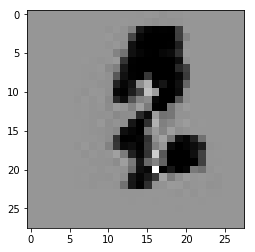

In [21]:
sample_image = generator(z_placeholder, 1, z_dimensions, reuse=True)
z_batch = np.random.normal(-1, 1, size=[1, z_dimensions])
temp = (sess.run(sample_image, feed_dict={z_placeholder: z_batch}))
my_i = temp.squeeze()
plt.imshow(my_i, cmap='gray_r')